## Introduction

ce notebook permet de : 
- Construire un graphe de similarité étudiant–étudiant (k-NN)
- Explorer plusieurs paramètres (k, seuil, normalisation)
- Évaluer la structure du graphe (modularité, pureté, connectivité)

Nous voulons un graphe ni trop dense ni trop fragmenté afin que les méthodes de détection de communautés soient pertinentes.

## configuration des chemins et des imports

In [ ]:
from pathlib import Path
import os
import sys
import importlib
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

CWD = Path.cwd()
ROOT = CWD.parent if CWD.name == "notebooks" else CWD

# --- Dossiers utiles ---
DATA_DIR = ROOT / "data"
ARTIFACTS_DIR = ROOT / "notebooks" / "artifacts"
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# --- verif des chemins psk prob ---
assert (DATA_DIR / "studentInfo.csv").exists(), f"⚠️ Introuvable: {DATA_DIR/'studentInfo.csv'}"
print("ROOT        =", ROOT)
print("DATA_DIR    =", DATA_DIR)
print("ARTIFACTS_DIR =", ARTIFACTS_DIR)

sys.path.insert(0, str(ROOT))

import src.data_preprocessing as dp
import src.graph_students as gs
importlib.reload(dp)
importlib.reload(gs)

# --- param généraux ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# --- param du module à étudier ---
MODULE = "AAA"
PRESENTATION = "2013J"

ROOT        = /Users/myriam/Desktop/Data Mining /projet/oulad-network-exploration
DATA_DIR    = /Users/myriam/Desktop/Data Mining /projet/oulad-network-exploration/data
ARTIFACTS_DIR = /Users/myriam/Desktop/Data Mining /projet/oulad-network-exploration/notebooks/artifacts


## Chargement et préparation du dataset

In [ ]:
student_data, X_raw, assess = dp.load_and_prepare_oulad(
    data_dir=DATA_DIR,
    module=MODULE,
    presentation=PRESENTATION,
)

print("Shape:", X_raw.shape)

# label filtré sur le module/préz courants et sans doublons
labels_df = student_data.loc[
    (student_data["code_module"] == MODULE) &
    (student_data["code_presentation"] == PRESENTATION),
    ["id_student", "final_result"]
].copy()

labels_df["final_result"] = labels_df["final_result"].replace({
    "Distinction": "Pass",
    "Withdrawn": "Fail"
})

labels = (labels_df.drop_duplicates(subset="id_student")
                    .set_index("id_student")["final_result"])


print("Labels uniques pour", MODULE, PRESENTATION, ":", labels.shape[0])

Shape: (378, 209)
Labels uniques pour AAA 2013J : 383


## Nomalisation / variante des données 

ici on teste plusieurs variante pour voir laquelle donne le meilleire graphe

In [20]:

X_variants = {
    "raw": X_raw.fillna(0),
    "rowmax": dp.normalize_rows_max(X_raw),
    "tfidf": dp.tfidf_rows(X_raw),
}

## Exploration des parametres 

In [21]:
param_grid = {
    "k": [5, 10, 15, 20, 30],
    "thr": [0.0, 0.1, 0.2, 0.3],
    "X_variant": ["raw", "rowmax", "tfidf"],
}

results = []
student_ids = X_raw.index.tolist()

for X_name in param_grid["X_variant"]:
    Xp = X_variants[X_name]
    sim = gs.build_similarity_matrix(Xp)
    
    for k in param_grid["k"]:
        for thr in param_grid["thr"]:
            G = gs.build_knn_graph(sim, student_ids, k=k, sim_threshold=thr)
            if not nx.is_connected(G):
                largest_cc = max(nx.connected_components(G), key=len)
                Gc = G.subgraph(largest_cc).copy()
            else:
                Gc = G

            part = gs.detect_communities(Gc, method="auto")
            eval_summary = gs.evaluate_partition(Gc, part)

            common_nodes = list(set(Gc.nodes()).intersection(labels.index))
            if common_nodes:
                y_true = labels.loc[common_nodes].astype(str).values
                y_pred = pd.Series(part)[common_nodes].values
                nmi = normalized_mutual_info_score(y_true, y_pred)
                ari = adjusted_rand_score(y_true, y_pred)
                purity, _, _ = gs.compute_purity(part, labels)
            else:
                nmi = ari = purity = np.nan

            results.append({
                "X": X_name, "k": k, "thr": thr,
                "n_nodes": Gc.number_of_nodes(),
                "n_edges": Gc.number_of_edges(),
                "modularity": eval_summary["modularity"],
                "n_comm": eval_summary["n_communities"],
                "purity": purity, "NMI": nmi, "ARI": ari
            })

results_df = pd.DataFrame(results)
results_df.sort_values("modularity", ascending=False).head(10)

,X,k,thr,n_nodes,n_edges,modularity,n_comm,purity,NMI,ARI
42,tfidf,5,0.2,378,1498,0.658520,10,0.817460,0.112520,0.057857
41,tfidf,5,0.1,378,1502,0.653738,9,0.817460,0.114021,0.059021
40,tfidf,5,0.0,378,1502,0.653738,9,0.817460,0.114021,0.059021
43,tfidf,5,0.3,376,1483,0.649216,9,0.824468,0.116349,0.054853
23,rowmax,5,0.3,378,1531,0.603212,9,0.806878,0.115622,0.036030
22,rowmax,5,0.2,378,1531,0.603212,9,0.806878,0.115622,0.036030
21,rowmax,5,0.1,378,1531,0.603212,9,0.806878,0.115622,0.036030
20,rowmax,5,0.0,378,1531,0.603212,9,0.806878,0.115622,0.036030
1,raw,5,0.1,378,1531,0.603212,9,0.806878,0.115622,0.036030
0,raw,5,0.0,378,1531,0.603212,9,0.806878,0.115622,0.036030


## Visu et choix des meilleures parametres 

- tab recupulatid des top resultats 
- graphique modularité vs k pour chaque type de normalisation 

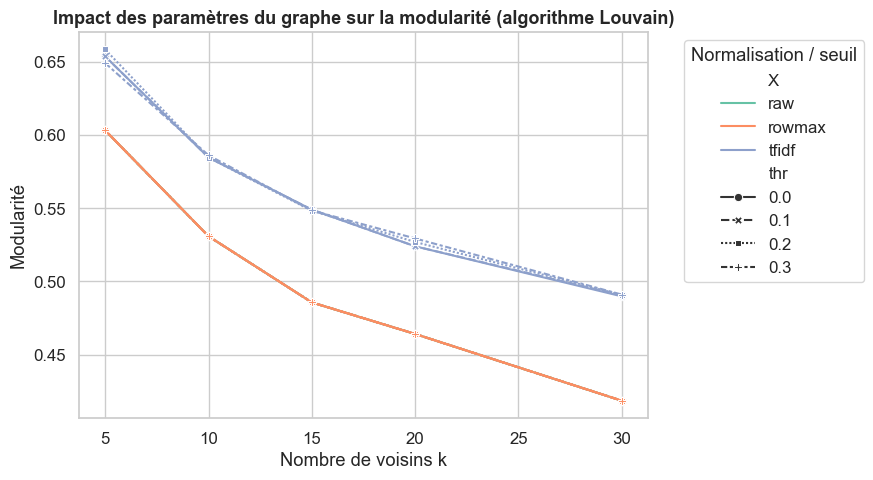

In [ ]:
plt.figure(figsize=(9, 5))
sns.set(style="whitegrid", font_scale=1.1)

sns.lineplot(
    data=results_df,
    x="k", y="modularity",
    hue="X", style="thr",
    markers=True, dashes=True, palette="Set2"
)

plt.title("Impact des paramètres du graphe sur la modularité (algorithme Louvain)", fontsize=13, weight="bold")
plt.xlabel("Nombre de voisins k")
plt.ylabel("Modularité")
plt.legend(title="Normalisation / seuil", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

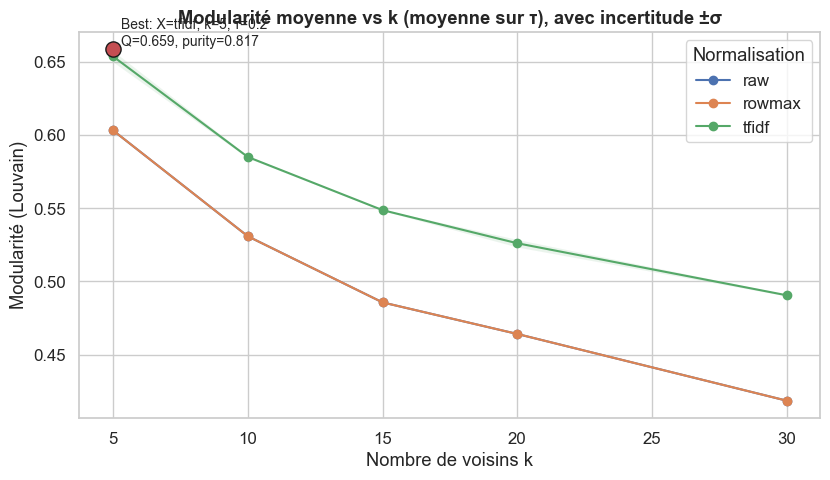

In [ ]:

mean_df = results_df.groupby(["X","k"], as_index=False)["modularity"].mean()
std_df  = results_df.groupby(["X","k"], as_index=False)["modularity"].std().rename(columns={"modularity":"std"})
plot_df = mean_df.merge(std_df, on=["X","k"], how="left")

best_row = results_df.sort_values("modularity", ascending=False).iloc[0]  # meilleur conbi (tfidf, k=5, thr=0.2)

plt.figure(figsize=(8.5,5))
sns.set(style="whitegrid", font_scale=1.1)
for x_name, sub in plot_df.groupby("X"):
    plt.plot(sub["k"], sub["modularity"], marker="o", label=x_name)
    plt.fill_between(sub["k"], sub["modularity"]-sub["std"], sub["modularity"]+sub["std"], alpha=0.12)

# ppour annoter le meilleur point 
plt.scatter([best_row["k"]], [best_row["modularity"]], s=120, edgecolor="k", zorder=5)
plt.text(best_row["k"]+0.3, best_row["modularity"]+0.003,
         f"Best: X={best_row['X']}, k={int(best_row['k'])}, τ={best_row['thr']}\nQ={best_row['modularity']:.3f}, purity={best_row['purity']:.3f}",
         fontsize=10)

plt.title("Modularité moyenne vs k (moyenne sur τ), avec incertitude ±σ", weight="bold")
plt.xlabel("Nombre de voisins k"); plt.ylabel("Modularité (Louvain)")
plt.legend(title="Normalisation")
plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / "fig_modularity_mean_std.png", dpi=300)
plt.show()


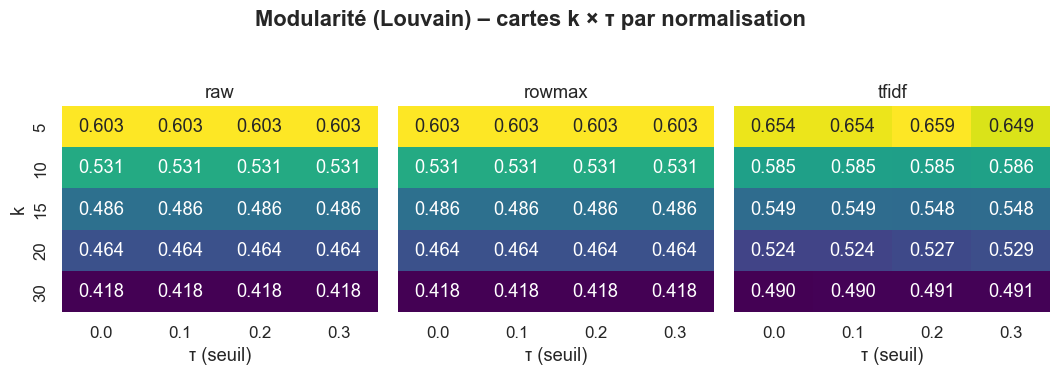

In [ ]:
hm_df = results_df.pivot_table(index="k", columns=["X","thr"], values="modularity")

g = sns.FacetGrid(results_df, col="X", sharex=True, sharey=True, height=3.6, aspect=1.0)
def _heat(data, color, **kws):
    mat = data.pivot(index="k", columns="thr", values="modularity")
    sns.heatmap(mat, annot=True, fmt=".3f", cmap="viridis", cbar=False, **kws)

g.map_dataframe(_heat)
g.set_axis_labels("τ (seuil)", "k")
g.set_titles("{col_name}")
g.fig.suptitle("Modularité (Louvain) – cartes k × τ par normalisation", y=1.04, weight="bold")
plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / "fig_heatmaps_k_thr_by_norm.png", dpi=300, bbox_inches="tight")
plt.show()

## graphe final selectionné 

X                tfidf
k                    5
thr                0.2
n_nodes            378
n_edges           1498
modularity     0.65852
n_comm              10
purity         0.81746
NMI            0.11252
ARI           0.057857
Name: 42, dtype: object


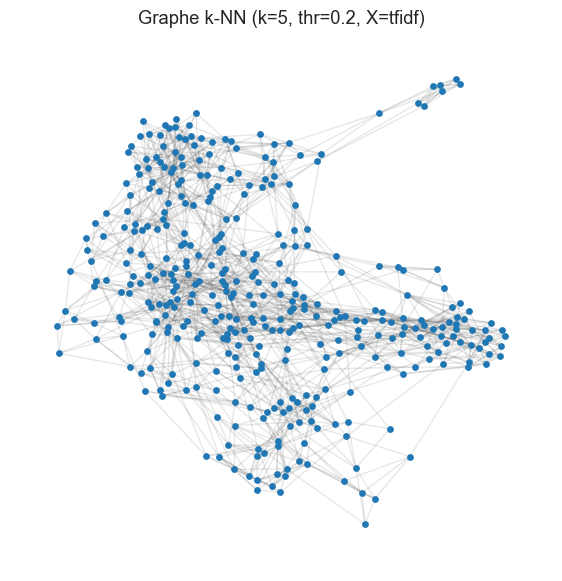

In [29]:
best_conf = results_df.loc[results_df["modularity"].idxmax()]
print(best_conf)

X_sel = X_variants[best_conf["X"]]
sim = gs.build_similarity_matrix(X_sel)
G_best = gs.build_knn_graph(sim, student_ids, int(best_conf["k"]), best_conf["thr"])

largest_cc = max(nx.connected_components(G_best), key=len)
G_best = G_best.subgraph(largest_cc).copy()

plt.figure(figsize=(7,7))
pos = nx.spring_layout(G_best, seed=RANDOM_STATE)
nx.draw_networkx_edges(G_best, pos, alpha=0.1)
nx.draw_networkx_nodes(G_best, pos, node_size=15)
plt.title(f"Graphe k-NN (k={best_conf['k']}, thr={best_conf['thr']}, X={best_conf['X']})")
plt.axis('off')
plt.show()

In [30]:
best_row = results_df.sort_values("modularity", ascending=False).iloc[0]
best_config = dict(X=best_row["X"], k=int(best_row["k"]), thr=float(best_row["thr"]))
best_row

print(f"Configuration optimale : X={best_config['X']}, k={best_config['k']}, τ={best_config['thr']}")
print(f"→ Modularity = {best_row['modularity']:.3f}, Purity = {best_row['purity']:.3f}, "
      f"NMI = {best_row['NMI']:.3f}, ARI = {best_row['ARI']:.3f}")


Configuration optimale : X=tfidf, k=5, τ=0.2
→ Modularity = 0.659, Purity = 0.817, NMI = 0.113, ARI = 0.058


In [ ]:
n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()
density = nx.density(G)
avg_deg = sum(dict(G.degree()).values()) / n_nodes
clust = nx.average_clustering(G, weight='weight')

print(f"Nombre de nœuds : {n_nodes}")
print(f"Nombre d'arêtes : {n_edges}")
print(f"Densité : {density:.4f}")
print(f"Degré moyen : {avg_deg:.2f}")
print(f"Clustering moyen (pondéré) : {clust:.3f}")

components = list(nx.connected_components(G))
print(f"Composantes connexes : {len(components)}")
print(f"Taille de la plus grande composante : {len(max(components, key=len))}")


Nombre de nœuds : 378
Nombre d'arêtes : 1498
Densité : 0.0210
Degré moyen : 7.93
Clustering moyen (pondéré) : 0.226
Composantes connexes : 1
Taille de la plus grande composante : 378


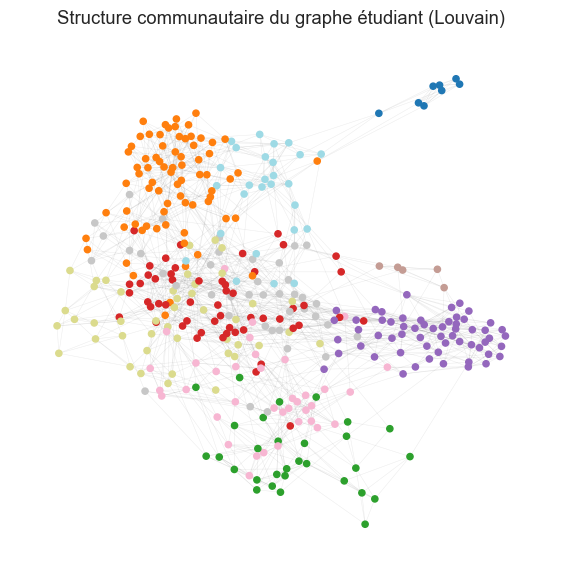

In [35]:
part = gs.detect_communities(G, method="louvain")
colors = pd.Series(part).astype("category").cat.codes

plt.figure(figsize=(7,7))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_edges(G, pos, alpha=0.08, width=0.4)
nx.draw_networkx_nodes(G, pos, node_size=20, node_color=colors, cmap="tab20")
plt.title("Structure communautaire du graphe étudiant (Louvain)")
plt.axis('off')
plt.show()

### pour mettre en lien les communautés avec le re final histoire de voir si deja on obtient qq chose de plausible

In [36]:
overall_purity, per_comm_purity, sizes = gs.compute_purity(part, labels)
df_comm = pd.DataFrame({
    "community": list(per_comm_purity.keys()),
    "size": [sizes[c] for c in per_comm_purity],
    "purity": list(per_comm_purity.values())
}).sort_values("size", ascending=False)
df_comm.head(10)

,community,size,purity
1,1,74,0.918919
3,4,59,0.813559
0,3,54,0.925926
6,8,44,0.613636
5,7,40,0.825000
4,6,37,0.594595
2,2,30,0.900000
7,9,27,0.851852
8,0,8,1.000000
9,5,5,0.600000
